# Pipeline
Abbiamo visto che quando eseguiamo un processo di data mining applichiamo una sequenza di operazioni, ad esempio prepariamo i dati codificandoli in un certo formato, eseguiamo il train di un modello, e così via.

Tutte queste operazioni possono essere composte in una pipeline.
In Scikit una pipeline è una sequenza di estimatori che vengono eseguiti uno dopo l’altro.

Deve essere definita inserendo i vari estimatori in un array nell’ordine in cui si vogliono eseguire. Vanno inseriti come una tupla dove il primo valore è una stringa che identifica lo stimatore e il secondo è lo stimatore stesso.


Prendiamo il dataset del Titanic da Seaborn e applichiamo alcune delle operazioni di pulizia iniziali che avevamo già visto.


In [2]:
import pandas as pd
import seaborn as sns

df = sns.load_dataset('titanic')

# Eliminamo valori nulli
df.drop('deck', axis=1, inplace=True)
df.dropna(subset=['embarked', 'embark_town'], inplace=True)
# Eliminiamo i campi duplicati/non necessari
df.drop(['class', 'who', 'class', 'adult_male', 'embark_town', 'alive', 'alone'], axis=1, inplace=True)
df['family_size'] = df['sibsp'] + df['parch'] + 1
df.drop(['sibsp', 'parch'], axis=1, inplace=True)
# Convertiamo i campi non numerici in numerici
df['sex'] = pd.factorize(df['sex'])[0]
df['embarked'] = pd.factorize(df['embarked'])[0]

df.head(2)

,survived,pclass,sex,age,fare,embarked,family_size
0,0,3,0,22.0,7.2500,0,2
1,1,1,1,38.0,71.2833,1,2


Ora supponiamo di voler:
*	Voler sostituire eventuali valori nulli con la moda
*	Scalare tutti i valori nel range [0, 1] in modo che il modello non dia un valore più alto a valori maggiori visto che rappresentano entità diversi (esempio, l’età e il costo del biglietto sono entrambi valori numerici ma diversi);
*	Non usare tutte le feature, ma solo le 3 migliori per mantenere un modello più semplice;
*	Usare come modello un classificatore di tipo RandomForest.

Dovremmo eseguire queste operazioni manualmente applicando fit/transform e salvare ogni volta il dataframe risultante.

Possiamo, invece, includere tutto in una pipeline:


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
scaler = MinMaxScaler()
selector = SelectKBest(k=3)
pipe = Pipeline([('imp', imp), ('scaler', scaler), ('selector', selector), ('model', RandomForestClassifier())])

pipe

Pipeline(steps=[('imp', SimpleImputer(strategy='most_frequent')),
                ('scaler', MinMaxScaler()), ('selector', SelectKBest(k=3)),
                ('model', RandomForestClassifier())])

In [6]:
from sklearn.model_selection import train_test_split

#Fatto questo, è possibile dividere i dati in train e test:
X = df.drop('survived', axis=1)
y = df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Ora è possibile utilizzare il metodo fit della pipeline per addestrare in sequenza tutti gli stimatori. Ad esempio, SimpleImputer imparerà qual è la moda di ogni feature, SelectKBest quali sono le migliori 3 feature rispetto alla variabile da predire (può usare ANOVA, chi2, correlazione, in base alle caratteristiche delle feature). I dati verranno poi processati e utilizzati per allenare il RandomForest.

Una volta fatto questo, si ottiene una pipeline allenata che supporta il metodo predict. Quando si applica predict le stesse operazioni vengono applicate sulle feature del test set: quindi vengono sostituiti i valori nulli di ogni feature con la moda calcolata sul training set, vengono scalati i valori, vengono mantenute solo le feature più rilevanti calcolate sul traning set e infine vengono passati i dati trasformati al classificatore per ottenere le predizioni.

0.8033707865168539
0.7681159420289855
0.7361111111111112


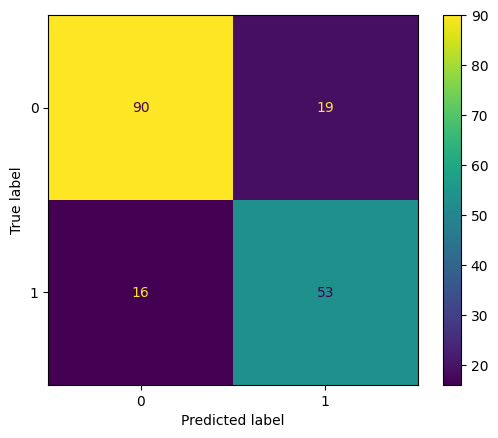

In [7]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, confusion_matrix


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)


print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=pipe.classes_).plot()

# Scelta dei parametri
La maggior parte dei modelli di scikit dispone di diversi parametri di ottimizzazione che possono influenzare il risultato delle predizioni.

Scegliere i migliori parametri non è semplice, spesso conviene procedere in via sperimentale, provando il modello con differenti parametri per trovare la configurazione ottimale.
Farlo manualmente può diventare un processo lungo e noioso: se ci sono vari parametri, bisogna provare e analizzare tutte le possibili combinazioni.

Scikit mette a disposizione un metodo chiamato `GridSearchCV` che prende in input: un dataset, un estimatore,  un dizionario che contiene per ogni parametro una serie di valori da provare, una o più metriche di valutazione (ad esempio, accuracy, recall, precision, etc.)  e applica il processo di cross validation su di un dataset testando le varie combinazioni di parametri.
Alla fine è possibile ottenere i migliori parametri e vedere per ogni combinazione le metriche.

Notare che l’estimatore in ingresso può essere una pipeline, in questo caso per specificare di quale estimatore si sta specificando il parametro bisogna mettere nomestimatore__nomeparametro. Dove nomestimatore è quello che gli si è assegnato quando si è definita la pipeline (la stringa nella tupla).

Vediamo un esempio, carichiamo il dataset tips di Seaborn e codifichiamo i valori non numerici.


In [8]:
df = sns.load_dataset("tips")
df['sex'] = pd.factorize(df['sex'])[0]
df['smoker'] = pd.factorize(df['smoker'])[0]
df['day'] = pd.factorize(df['day'])[0]
df['time'] = pd.factorize(df['time'])[0]

Ora definiamo una pipeline che:
  1.	Scala i valori
  2.	Seleziona le migliori k features
  3.	Applica un modello di regressione, in questo caso utilizziamo SGDRegressor (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) perché ha molti parametri rispetto a una regressione lineare standard.


In [9]:
from sklearn.linear_model import SGDRegressor

pipe = Pipeline([('scaler', MinMaxScaler()), ('selector', SelectKBest()), ('model', SGDRegressor())])

Ora definiamo un dictionary con i parametri da provare

In [10]:
parametri = {
    'selector__k': np.arange(1, 7),
    'model__loss': ['squared_error', 'huber', 'epsilon_insensitive'],
    'model__penalty': ['l2', 'l1'],
    'model__alpha': [0.0001, 0.001, 0.01, 0.1]
}

Si può ora definire GridSearchCV, prendiamo come metrica lo scarto quadratico medio.

In [12]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(pipe, param_grid=parametri, cv=5, scoring='neg_root_mean_squared_error')

Testiamo i vari parametri

In [13]:
X = df.drop('tip', axis=1)
y = df['tip']
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('selector', SelectKBest()),
                                       ('model', SGDRegressor())]),
             param_grid={'model__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'model__loss': ['squared_error', 'huber',
                                         'epsilon_insensitive'],
                         'model__penalty': ['l2', 'l1'],
                         'selector__k': array([1, 2, 3, 4, 5, 6])},
             scoring='neg_root_mean_squared_error')

Accedendo a `grid.best_params_` possiamo vedere i parametri migliori selezionati sulla base della metrica scelta

In [14]:
grid.best_params_

{'model__alpha': 0.0001,
 'model__loss': 'squared_error',
 'model__penalty': 'l1',
 'selector__k': np.int64(3)}

La proprietà grid.best_score_ contiene lo score ottenuto dalla miglior configurazione utilizzando la cross validation.

Siccome scikit cerca di massimizzare le metriche e abbiamo impostato rmse che più è piccola meglio è, allora questa viene negata. Ritornerà un valore negativo di rmse.


In [19]:
print(-grid.best_score_)

1.0632628372342352


Una volta allenato grid può essere usato per fare predizioni, utilizzerà la pipeline con le impostazioni migliori.

Quindi supporta il metodo `grid.predict`